# Imports:

In [50]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.stats import gaussian_kde
import seaborn as sns
from skimage import morphology
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import pydicom
from pascal_voc_tools.xml_tools import PascalXml

%matplotlib widget

# Reading Data:

### Reading patients statistics:

In [2]:
if __name__ == "__main__":
    statistics = pd.read_excel("Data/Cancer_types/statistics-clinical-20201221.xlsx")

In [3]:
statistics

,No.,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,Ｍ-Stage,Histopathological grading,Smoking History
0,1,A0001,M,58.0,65.0,2b,3,1b,G3,1
1,2,A0002,F,53.0,55.0,2b,1,0,NaN,0
2,3,A0003,M,60.0,62.0,1c,1,0,G3,0
3,4,A0004,F,48.0,56.0,1c,3,0,NaN,0
4,5,A0005,M,70.0,75.0,1b,0,0,G2,1
...,...,...,...,...,...,...,...,...,...,...
350,351,G0057,M,72.0,67.5,1c,0,0,G2,1
351,352,G0058,M,57.0,55.0,4,0,0,NaN,1
352,353,G0059,M,53.0,62.0,1b,0,0,NaN,1
353,354,G0060,M,57.0,74.0,2a,1,0,NaN,0


In [51]:
annotations = pd.read_xml("Data/Cancer_types/LIDC-XML-only/161-resubmitted-correction-3-9-12.xml")

In [52]:
annotations

,Version,MessageId,DateRequest,TimeRequest,RequestingSite,ServicingSite,TaskDescription,CtImageFile,SeriesInstanceUid,StudyInstanceUID,DateService,TimeService,ResponseDescription,ResponseComments,annotationVersion,servicingRadiologistID,unblindedReadNodule,nonNodule
0,1.7,1152727.0,2006-06-05,17:08:37,removed,removed,Second unblinded read,removed,1.3.6.1.4.1.14519.5.2.1.6279.6001.340202188094...,1.3.6.1.4.1.14519.5.2.1.6279.6001.584233139051...,2006-06-05,17:08:37,1 - Reading complete,"Merged, reader anonymized, unblinded responses",NaN,None,None,None
1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,3.12,anonymous,\n,\n
2,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,3.12,anonymous,\n,\n
3,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,3.12,anonymous,\n,\n
4,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,3.12,anonymous,\n,\n


In [53]:
dicom_file = pydicom.dcmread("Data/Cancer_types/Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-Chest-07990/2.000000-5mm-40805/1-32.dcm")

In [54]:
print(dicom_file)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 204
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6655.2359.255912996966178256047133446660
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008,0012) Instance Creation Date              DA: '20070404'
(0008,0013) Instance Creation Time              TM: '190125'
(0008,0016) SOP Class UID              

In [55]:
# Access pixel data (image)
image_data = dicom_file.pixel_array
print(image_data[200:300, 200:300])  # Dimensions of the image

[[  84  125  248 ... 1042 1119 1003]
 [ 128  184  190 ... 1050 1098 1024]
 [  89  184  174 ... 1002 1029 1103]
 ...
 [ 208  179  335 ... 1117 1143 1042]
 [ 204   50  169 ... 1084 1056 1050]
 [  83   54  204 ... 1084 1065 1069]]


In [56]:
def visualize_image(image):
    # Create figure and adjust layout to make room for slider if needed
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the slice (CT scan) in grayscale
    im = ax.imshow(image, cmap="gray")
    ax.set_title(f"CT Scan Slice {slice}")
    ax.axis("off")

    plt.show()

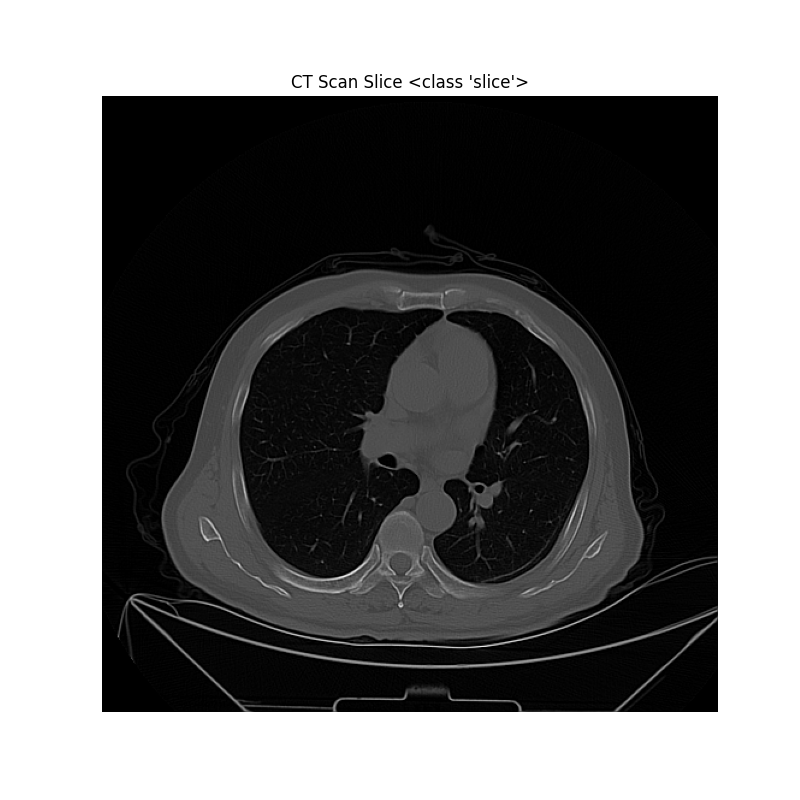

In [57]:
visualize_image(image_data)

In [4]:
# Load the XML file
xml_path = "Data/Cancer_types/LIDC-XML-only/tcia-lidc-xml/157/163.xml"
voc = PascalXml(xml_path)

# Access general information
print(f"Filename: {voc.filename}")
print(f"Image size: {voc.width}x{voc.height}")

# Iterate over objects
for obj in voc.objects:
    print(f"Object: {obj.name}, BBox: ({obj.xmin}, {obj.ymin}, {obj.xmax}, {obj.ymax})")

Filename: 


AttributeError: 'PascalXml' object has no attribute 'width'

In [5]:
from pascal_voc_tools.annotations_tools import Annotations

# Create an Annotations object
annotations = Annotations()

# Add an object with a bounding box
annotations.add_object(name="cat", xmin=100, ymin=200, xmax=300, ymax=400)

# Print all objects
for obj in annotations.objects:
    print(f"Object: {obj.name}, BBox: ({obj.xmin}, {obj.ymin}, {obj.xmax}, {obj.ymax})")

TypeError: Annotations.__init__() missing 1 required positional argument: 'ann_dir'

In [10]:
from pascal_voc_tools.annotations_tools import Annotations

# Path to the directory containing annotation files
ann_dir = "Data/Cancer_types/LIDC-XML-only/tcia-lidc-xml/157"

# Create an Annotations object
annotations = Annotations(ann_dir)

# Inspect the Annotations object
print(dir(annotations))

annotations.load_annotations()

for obj in annotations.objects:
    print(f"Object: {obj.name}, BBox: ({obj.xmin}, {obj.ymin}, {obj.xmax}, {obj.ymax})")

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ann_list', 'convert2csv', 'count_category', 'dir', 'get_bbox_info', 'height_analyse', 'iou_analyse', 'load', 'width_analyse']


AttributeError: 'Annotations' object has no attribute 'load_annotations'

In [11]:
import xml.etree.ElementTree as ET

# Load and parse the XML file
tree = ET.parse('Data/Cancer_types/LIDC-XML-only/tcia-lidc-xml/157/158.xml')
root = tree.getroot()

# Namespace dictionary to handle the namespace in the XML
namespaces = {'ns': 'http://www.nih.gov'}

# Function to extract and print nodule information
def extract_nodule_info(nodule):
    nodule_id = nodule.find('ns:noduleID', namespaces).text
    print(f"Nodule ID: {nodule_id}")
    
    characteristics = nodule.find('ns:characteristics', namespaces)
    if characteristics is not None:
        print("Characteristics:")
        for characteristic in characteristics:
            print(f"  {characteristic.tag.split('}')[1]}: {characteristic.text}")
    
    rois = nodule.findall('ns:roi', namespaces)
    for roi in rois:
        image_zposition = roi.find('ns:imageZposition', namespaces).text
        image_sop_uid = roi.find('ns:imageSOP_UID', namespaces).text
        inclusion = roi.find('ns:inclusion', namespaces).text
        print(f"  ROI - Image Z Position: {image_zposition}, SOP UID: {image_sop_uid}, Inclusion: {inclusion}")
        
        edge_maps = roi.findall('ns:edgeMap', namespaces)
        for edge_map in edge_maps:
            x_coord = edge_map.find('ns:xCoord', namespaces).text
            y_coord = edge_map.find('ns:yCoord', namespaces).text
            print(f"    Edge Map - X: {x_coord}, Y: {y_coord}")

# Function to extract and print non-nodule information
def extract_non_nodule_info(non_nodule):
    non_nodule_id = non_nodule.find('ns:nonNoduleID', namespaces).text
    image_zposition = non_nodule.find('ns:imageZposition', namespaces).text
    image_sop_uid = non_nodule.find('ns:imageSOP_UID', namespaces).text
    locus = non_nodule.find('ns:locus', namespaces)
    x_coord = locus.find('ns:xCoord', namespaces).text
    y_coord = locus.find('ns:yCoord', namespaces).text
    print(f"Non-Nodule ID: {non_nodule_id}, Image Z Position: {image_zposition}, SOP UID: {image_sop_uid}, Locus - X: {x_coord}, Y: {y_coord}")

# Iterate over each reading session
for reading_session in root.findall('ns:readingSession', namespaces):
    print("Reading Session:")
    
    # Extract and print unblinded read nodules
    unblinded_read_nodules = reading_session.findall('ns:unblindedReadNodule', namespaces)
    for nodule in unblinded_read_nodules:
        extract_nodule_info(nodule)
    
    # Extract and print non-nodules
    non_nodules = reading_session.findall('ns:nonNodule', namespaces)
    for non_nodule in non_nodules:
        extract_non_nodule_info(non_nodule)
    
    print("\n")

Reading Session:
Nodule ID: 0
  ROI - Image Z Position: 1604.5, SOP UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.192028152416081898151427003898, Inclusion: TRUE
    Edge Map - X: 177, Y: 353
Nodule ID: 3
Characteristics:
  subtlety: 5
  internalStructure: 1
  calcification: 6
  sphericity: 3
  margin: 4
  lobulation: 1
  spiculation: 1
  texture: 5
  malignancy: 3
  ROI - Image Z Position: 1550.5, SOP UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.498089111228175009979138545584, Inclusion: TRUE
    Edge Map - X: 364, Y: 172
    Edge Map - X: 364, Y: 171
    Edge Map - X: 364, Y: 170
    Edge Map - X: 365, Y: 169
    Edge Map - X: 365, Y: 168
    Edge Map - X: 365, Y: 167
    Edge Map - X: 365, Y: 166
    Edge Map - X: 365, Y: 165
    Edge Map - X: 365, Y: 164
    Edge Map - X: 365, Y: 163
    Edge Map - X: 364, Y: 164
    Edge Map - X: 363, Y: 164
    Edge Map - X: 362, Y: 165
    Edge Map - X: 361, Y: 166
    Edge Map - X: 360, Y: 167
    Edge Map - X: 359, Y: 168
    Edge Map - X: 359, Y: 169
    

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd

# Load and parse the XML file
tree = ET.parse('Data/Cancer_types/LIDC-XML-only/tcia-lidc-xml/157/158.xml')
root = tree.getroot()

# Namespace dictionary to handle the namespace in the XML
namespaces = {'ns': 'http://www.nih.gov'}

# Lists to store extracted data
nodules_data = []
non_nodules_data = []

# Function to extract nodule information
def extract_nodule_info(nodule):
    nodule_id = nodule.find('ns:noduleID', namespaces).text
    
    characteristics = nodule.find('ns:characteristics', namespaces)
    if characteristics is not None:
        char_dict = {elem.tag.split('}')[1]: elem.text for elem in characteristics}
    else:
        char_dict = {}
    
    rois = nodule.findall('ns:roi', namespaces)
    for roi in rois:
        image_zposition = roi.find('ns:imageZposition', namespaces).text
        image_sop_uid = roi.find('ns:imageSOP_UID', namespaces).text
        inclusion = roi.find('ns:inclusion', namespaces).text
        
        edge_maps = roi.findall('ns:edgeMap', namespaces)
        for edge_map in edge_maps:
            x_coord = edge_map.find('ns:xCoord', namespaces).text
            y_coord = edge_map.find('ns:yCoord', namespaces).text
            
            # Combine all data into a dictionary
            nodule_info = {
                'Nodule ID': nodule_id,
                'Image Z Position': image_zposition,
                'SOP UID': image_sop_uid,
                'Inclusion': inclusion,
                'X Coordinate': x_coord,
                'Y Coordinate': y_coord,
                **char_dict  # Add characteristics to the dictionary
            }
            nodules_data.append(nodule_info)

# Function to extract non-nodule information
def extract_non_nodule_info(non_nodule):
    non_nodule_id = non_nodule.find('ns:nonNoduleID', namespaces).text
    image_zposition = non_nodule.find('ns:imageZposition', namespaces).text
    image_sop_uid = non_nodule.find('ns:imageSOP_UID', namespaces).text
    locus = non_nodule.find('ns:locus', namespaces)
    x_coord = locus.find('ns:xCoord', namespaces).text
    y_coord = locus.find('ns:yCoord', namespaces).text
    
    non_nodule_info = {
        'Non-Nodule ID': non_nodule_id,
        'Image Z Position': image_zposition,
        'SOP UID': image_sop_uid,
        'X Coordinate': x_coord,
        'Y Coordinate': y_coord
    }
    non_nodules_data.append(non_nodule_info)

# Iterate over each reading session
for reading_session in root.findall('ns:readingSession', namespaces):
    # Extract and store unblinded read nodules
    unblinded_read_nodules = reading_session.findall('ns:unblindedReadNodule', namespaces)
    for nodule in unblinded_read_nodules:
        extract_nodule_info(nodule)
    
    # Extract and store non-nodules
    non_nodules = reading_session.findall('ns:nonNodule', namespaces)
    for non_nodule in non_nodules:
        extract_non_nodule_info(non_nodule)

# Convert lists to DataFrames
nodules_df = pd.DataFrame(nodules_data)
non_nodules_df = pd.DataFrame(non_nodules_data)

# Save DataFrames to CSV files (optional)
nodules_df.to_csv('nodules.csv', index=False)
non_nodules_df.to_csv('non_nodules.csv', index=False)

# Print DataFrames
print("Nodules DataFrame:")
print(nodules_df)
print("\nNon-Nodules DataFrame:")
print(non_nodules_df)

Nodules DataFrame:
     Nodule ID Image Z Position  \
0            0           1604.5   
1            3           1550.5   
2            3           1550.5   
3            3           1550.5   
4            3           1550.5   
...        ...              ...   
5707      2054           1475.5   
5708      2054           1475.5   
5709      2054           1475.5   
5710      2054           1475.5   
5711      2054           1475.5   

                                                SOP UID Inclusion  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.192028152416...      TRUE   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.498089111228...      TRUE   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.498089111228...      TRUE   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.498089111228...      TRUE   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.498089111228...      TRUE   
...                                                 ...       ...   
5707  1.3.6.1.4.1.14519.5.2.1.6279.6001.712805449042...      TRUE   
5708  1.

In [18]:
metadata = pd.read_csv("Data/Cancer_types/metadata.csv", index_col=False)

C:\Users\ibrah\AppData\Local\Temp\ipykernel_7308\3056841507.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  metadata = pd.read_csv("Data/Cancer_types/metadata.csv", index_col=False)


In [20]:
metadata["Subject ID"]

0       Lung_Dx-A0002
1       Lung_Dx-A0001
2       Lung_Dx-A0002
3       Lung_Dx-A0001
4       Lung_Dx-A0003
            ...      
1291    Lung_Dx-A0256
1292    Lung_Dx-A0253
1293    Lung_Dx-A0256
1294    Lung_Dx-A0257
1295    Lung_Dx-A0265
Name: Subject ID, Length: 1296, dtype: object

In [34]:
cases = metadata.copy()

In [35]:
cases["Subject ID"] = cases["Subject ID"].str.replace('Lung_Dx-', '', regex=True)

In [43]:
A_counts = cases[cases["Subject ID"].str.startswith('A', na=False)]["Subject ID"].count()
B_counts = cases[cases["Subject ID"].str.startswith('B', na=False)]["Subject ID"].count()
E_counts = cases[cases["Subject ID"].str.startswith('E', na=False)]["Subject ID"].count()
G_counts = cases[cases["Subject ID"].str.startswith('G', na=False)]["Subject ID"].count()

In [44]:
print (A_counts, B_counts, E_counts, G_counts)

952 112 11 221


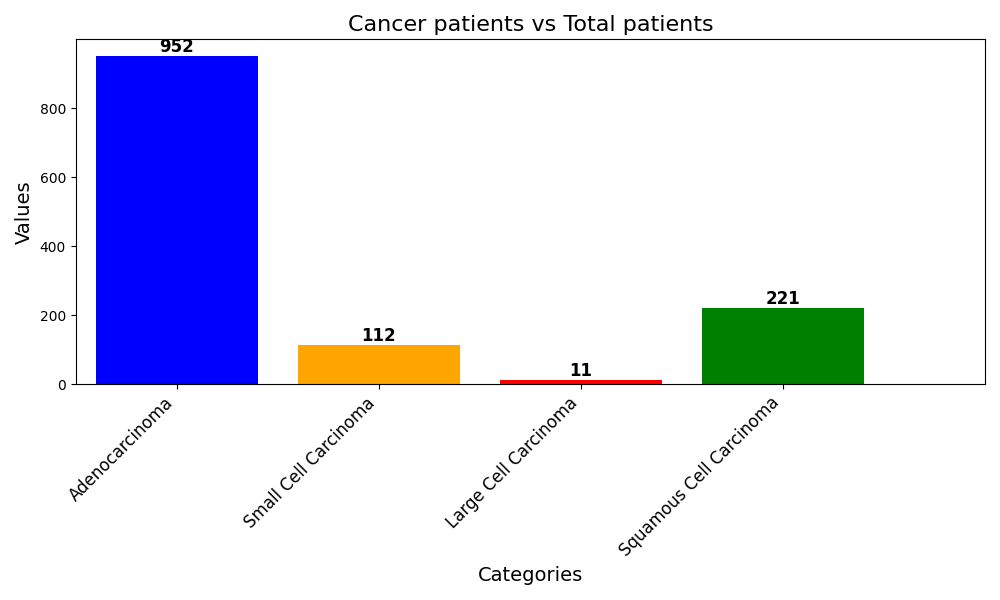

In [49]:
categories = ["Adenocarcinoma", "Small Cell Carcinoma", "Large Cell Carcinoma", "Squamous Cell Carcinoma"]
values = [A_counts, B_counts, E_counts, G_counts]  # Replace with your actual data

# Create bar plot with a larger figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Increase width to accommodate longer category names
bars = ax.bar(categories, values, color=['blue', 'orange', 'red', 'green'])

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Cancer patients vs Total patients', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels and align them to the right

# Extend the x-axis limits to add extra space
ax.set_xlim(-0.5, len(categories) - 0.5 + 0.5)  # Add extra space on the right

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Save and show plot
plt.savefig('Data_vis/Cancer_types/bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()